In [5]:
import pandas as pd

In [16]:
#df = pd.read_csv('/content/drive/MyDrive/capstone/noshowappointments-kagglev2-may-2016.csv', index_col = 'PatientId')

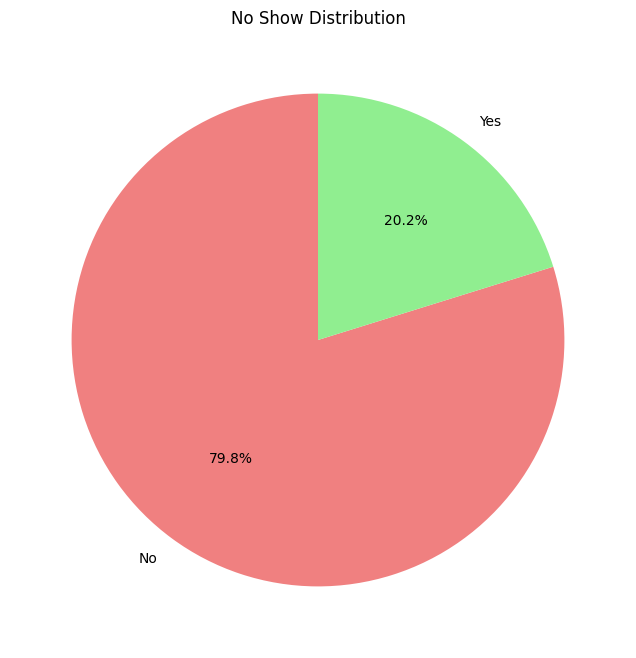

In [60]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Assuming df1 is your DataFrame
# # Assuming 'no_show' is the column containing 'Yes' and 'No'
# no_show_counts = df['No-show'].value_counts()

# # Plotting the pie chart
# plt.figure(figsize=(8, 8))
# plt.pie(no_show_counts, labels=no_show_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
# plt.title('No Show Distribution')
# plt.show()


In [6]:
#df.Neighbourhood.unique()

In [35]:
df1 = pd.read_csv('C:/Users/ritaf/Documents/GitHub/CP/Capstone/No_show_prediction/medical-appointments-no-show-en.csv')

In [36]:
df1.head()
# Temos 49593 rows

,specialty,appointment_time,gender,appointment_date,no_show,no_show_reason,disability,date_of_birth,entry_service_date,city,...,over_60_years_old,patient_needs_companion,average_temp_day,average_rain_day,max_temp_day,max_rain_day,rainy_day_before,storm_day_before,rain_intensity,heat_intensity
0,physiotherapy,13:20,M,09/09/2021,yes,surto,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
1,psychotherapy,13:20,M,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
2,speech therapy,13:20,F,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
3,physiotherapy,13:20,F,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
4,physiotherapy,14:00,M,09/09/2021,no,NaN,motor,10/10/1954,5/2/2020,B. CAMBORIU,...,1,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild


In [37]:
df1.info()
# Temos bastantes nans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49593 entries, 0 to 49592
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   specialty                42139 non-null  object 
 1   appointment_time         49593 non-null  object 
 2   gender                   49593 non-null  object 
 3   appointment_date         49593 non-null  object 
 4   no_show                  49593 non-null  object 
 5   no_show_reason           1737 non-null   object 
 6   disability               44456 non-null  object 
 7   date_of_birth            39272 non-null  object 
 8   entry_service_date       44438 non-null  object 
 9   city                     44412 non-null  object 
 10  icd                      10717 non-null  object 
 11  appointment_month        49593 non-null  object 
 12  appointment_year         49593 non-null  int64  
 13  appointment_shift        49593 non-null  object 
 14  age                   

In [38]:
df1.drop(['no_show_reason', 'icd'], axis = 1, inplace = True)
# dropamos as colunas com mais nans
# ICD é o código da doença

In [39]:
df1.dropna(inplace = True)
# ficamos com 34607 rows (dropamos 14986)

In [40]:
df1.specialty.unique()

array(['physiotherapy', 'occupational therapy', 'psychotherapy',
       'speech therapy', 'enf', 'assist', 'pedagogo', 'sem especialidade'],
      dtype=object)

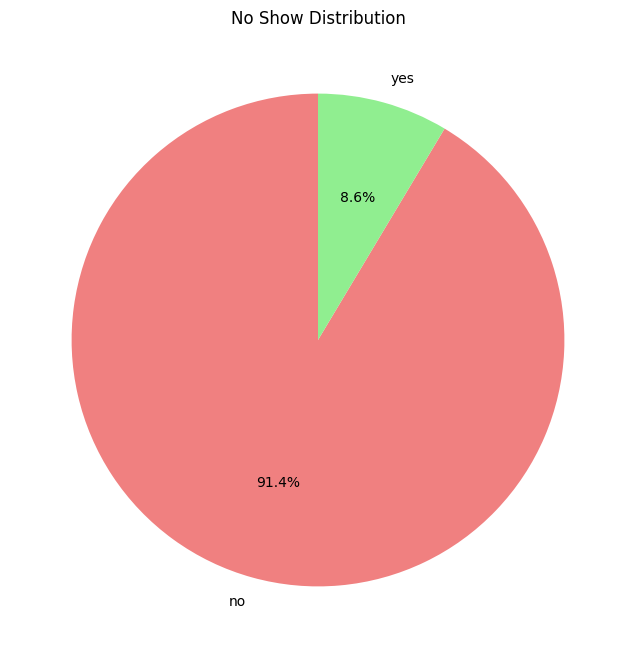

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df1 is your DataFrame
# Assuming 'no_show' is the column containing 'Yes' and 'No'
no_show_counts = df1['no_show'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(no_show_counts, labels=no_show_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title('No Show Distribution')
plt.show()


In [70]:
df1.city.unique()

array(['B. CAMBORIU', 'ITAJAÍ', 'CAMBORIU', 'NAVEGANTES', 'ILHOTA',
       'BOMBINHAS', 'ITAPEMA', 'PORTO BELO', 'PENHA', 'LUIZ ALVES',
       'BALN. PIÇARRAS'], dtype=object)

In [114]:
distances = {'B. CAMBORIU': 12.3,
              'ITAJAÍ': 2.4,
             'CAMBORIU': 14.2,
             'NAVEGANTES': 6.3,
             'ILHOTA': 23,
             'BOMBINHAS': 49.1,
             'ITAPEMA': 27.1,
             'PORTO BELO': 39.3,
             'PENHA': 28,
             'LUIZ ALVES': 44,
             'BALN. PIÇARRAS': 26.3
          }

In [115]:
df1['distances'] = df1['city'].map(distances)


In [92]:
df1

,specialty,appointment_time,gender,appointment_date,no_show,disability,date_of_birth,entry_service_date,city,appointment_month,...,patient_needs_companion,average_temp_day,average_rain_day,max_temp_day,max_rain_day,rainy_day_before,storm_day_before,rain_intensity,heat_intensity,distances
4,physiotherapy,14:00,M,09/09/2021,no,motor,10/10/1954,5/2/2020,B. CAMBORIU,sept,...,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild,12.3
5,occupational therapy,14:00,M,09/09/2021,no,intellectual,21/3/2017,26/11/2019,ITAJAÍ,sept,...,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild,2.4
6,psychotherapy,14:00,M,09/09/2021,no,intellectual,10/1/2011,1/10/2019,CAMBORIU,sept,...,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild,14.2
8,occupational therapy,14:00,M,09/09/2021,no,intellectual,21/3/2017,20/11/2019,ITAJAÍ,sept,...,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild,2.4
11,physiotherapy,14:40,F,09/09/2021,no,motor,8/2/1994,23/6/2020,NAVEGANTES,sept,...,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild,6.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49552,occupational therapy,17:00,M,01/03/2021,no,motor,29/6/1999,28/9/2020,ITAJAÍ,mar,...,0,22.55,4.22,24.6,32.8,1,1,heavy,mild,2.4
49554,speech therapy,17:00,F,01/03/2021,no,motor,15/7/1954,14/8/2019,ITAJAÍ,mar,...,1,22.55,4.22,24.6,32.8,1,1,heavy,mild,2.4
49556,physiotherapy,17:40,F,01/03/2021,no,motor,15/7/1954,14/8/2019,ITAJAÍ,mar,...,1,22.55,4.22,24.6,32.8,1,1,heavy,mild,2.4
49557,occupational therapy,17:40,F,01/03/2021,no,intellectual,11/7/2017,19/8/2019,BALN. PIÇARRAS,mar,...,1,22.55,4.22,24.6,32.8,1,1,heavy,mild,26.3


In [116]:
import pandas as pd

# Assuming df is your DataFrame and 'TIME_COLUMN' is the column with time values
df1['appointment_time'] = df1['appointment_time'].apply(lambda x: round(int(x.split(':')[0]) + int(x.split(':')[1]) / 60, 1))


In [94]:
df1

,specialty,appointment_time,gender,appointment_date,no_show,disability,date_of_birth,entry_service_date,city,appointment_month,...,patient_needs_companion,average_temp_day,average_rain_day,max_temp_day,max_rain_day,rainy_day_before,storm_day_before,rain_intensity,heat_intensity,distances
4,physiotherapy,14.0,M,09/09/2021,no,motor,10/10/1954,5/2/2020,B. CAMBORIU,sept,...,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild,12.3
5,occupational therapy,14.0,M,09/09/2021,no,intellectual,21/3/2017,26/11/2019,ITAJAÍ,sept,...,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild,2.4
6,psychotherapy,14.0,M,09/09/2021,no,intellectual,10/1/2011,1/10/2019,CAMBORIU,sept,...,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild,14.2
8,occupational therapy,14.0,M,09/09/2021,no,intellectual,21/3/2017,20/11/2019,ITAJAÍ,sept,...,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild,2.4
11,physiotherapy,14.7,F,09/09/2021,no,motor,8/2/1994,23/6/2020,NAVEGANTES,sept,...,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild,6.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49552,occupational therapy,17.0,M,01/03/2021,no,motor,29/6/1999,28/9/2020,ITAJAÍ,mar,...,0,22.55,4.22,24.6,32.8,1,1,heavy,mild,2.4
49554,speech therapy,17.0,F,01/03/2021,no,motor,15/7/1954,14/8/2019,ITAJAÍ,mar,...,1,22.55,4.22,24.6,32.8,1,1,heavy,mild,2.4
49556,physiotherapy,17.7,F,01/03/2021,no,motor,15/7/1954,14/8/2019,ITAJAÍ,mar,...,1,22.55,4.22,24.6,32.8,1,1,heavy,mild,2.4
49557,occupational therapy,17.7,F,01/03/2021,no,intellectual,11/7/2017,19/8/2019,BALN. PIÇARRAS,mar,...,1,22.55,4.22,24.6,32.8,1,1,heavy,mild,26.3


In [117]:
df1.drop('date_of_birth', axis = 1, inplace = True)

In [97]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34607 entries, 4 to 49558
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   specialty                34607 non-null  object 
 1   appointment_time         34607 non-null  float64
 2   gender                   34607 non-null  object 
 3   appointment_date         34607 non-null  object 
 4   no_show                  34607 non-null  object 
 5   disability               34607 non-null  object 
 6   entry_service_date       34607 non-null  object 
 7   city                     34607 non-null  object 
 8   appointment_month        34607 non-null  object 
 9   appointment_year         34607 non-null  int64  
 10  appointment_shift        34607 non-null  object 
 11  age                      34607 non-null  float64
 12  under_12_years_old       34607 non-null  int64  
 13  over_60_years_old        34607 non-null  int64  
 14  patient_needs_companio

In [123]:
import pandas as pd

# Assuming df1 is your DataFrame and 'entry_service_date' is the column with date values
try:
    df1['entry_service_date'] = pd.to_datetime(df1['entry_service_date'], format='%d/%m/%Y')
except ValueError as e:
    print(f"Error: {e}")
    print("The following entries have issues:")
    problematic_entries = df1.loc[pd.to_datetime(df1['entry_service_date'], errors='coerce').isnull(), 'entry_service_date']
    print(problematic_entries)


In [122]:
import pandas as pd

try:
    df1['entry_service_date'] = pd.to_datetime(df1['entry_service_date'].str.strip(), format='%d/%m/%Y')
except ValueError as e:
    print(f"Error: {e}")
    print("Deleting rows with problematic date formats.")
    df1 = df1.loc[pd.to_datetime(df1['entry_service_date'].str.strip(), errors='coerce').notnull()]

# Now df1 should contain only the rows with valid date formats


In [125]:
# Assuming df is your DataFrame and 'date_column' is the column with date values
import pandas as pd

# Assuming df1 is your DataFrame and 'entry_service_date' is the column with date values
df1['entry_service_date'] = pd.to_datetime(df1['entry_service_date'], format='%d/%m/%Y')
df1['recency'] = pd.to_datetime('now') - pd.to_datetime(df1['entry_service_date'])
df1['recency'] = df1['recency'].dt.days


<ipython-input-125-cd4e793cdc9b>:6: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  df1['recency'] = pd.to_datetime('now') - pd.to_datetime(df1['entry_service_date'])


In [127]:
df1.isna().any()

specialty                  False
appointment_time           False
gender                     False
appointment_date           False
no_show                    False
disability                 False
entry_service_date         False
city                       False
appointment_month          False
appointment_year           False
appointment_shift          False
age                        False
under_12_years_old         False
over_60_years_old          False
patient_needs_companion    False
average_temp_day           False
average_rain_day           False
max_temp_day               False
max_rain_day               False
rainy_day_before           False
storm_day_before           False
rain_intensity             False
heat_intensity             False
distances                  False
recency                    False
dtype: bool

In [128]:
df1.drop('entry_service_date', axis = 1, inplace = True)

In [130]:
df1.T

,4,5,6,8,11,12,13,14,16,18,...,49546,49547,49549,49550,49551,49552,49554,49556,49557,49558
specialty,physiotherapy,occupational therapy,psychotherapy,occupational therapy,physiotherapy,occupational therapy,psychotherapy,psychotherapy,speech therapy,physiotherapy,...,speech therapy,speech therapy,occupational therapy,psychotherapy,psychotherapy,occupational therapy,speech therapy,physiotherapy,occupational therapy,psychotherapy
appointment_time,14.0,14.0,14.0,14.0,14.7,14.7,14.7,14.7,14.7,15.3,...,16.3,16.3,17.0,17.0,17.0,17.0,17.0,17.7,17.7,17.7
gender,M,M,M,M,F,M,M,F,M,M,...,F,F,F,F,F,M,F,F,F,M
appointment_date,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,09/09/2021,...,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021,01/03/2021
no_show,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
disability,motor,intellectual,intellectual,intellectual,motor,motor,intellectual,intellectual,intellectual,motor,...,intellectual,intellectual,intellectual,intellectual,intellectual,motor,motor,motor,intellectual,motor
city,B. CAMBORIU,ITAJAÍ,CAMBORIU,ITAJAÍ,NAVEGANTES,B. CAMBORIU,ITAJAÍ,ILHOTA,ITAJAÍ,BOMBINHAS,...,BALN. PIÇARRAS,ITAPEMA,ITAPEMA,ITAPEMA,BALN. PIÇARRAS,ITAJAÍ,ITAJAÍ,ITAJAÍ,BALN. PIÇARRAS,ITAJAÍ
appointment_month,sept,sept,sept,sept,sept,sept,sept,sept,sept,sept,...,mar,mar,mar,mar,mar,mar,mar,mar,mar,mar
appointment_year,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
appointment_shift,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,...,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon,afternoon


In [146]:
df1.drop('appointment_shift', axis=1, inplace = True)

In [132]:
df1.heat_intensity.unique()

array(['mild', 'cold', 'warm', 'heavy_warm', 'heavy_cold'], dtype=object)

In [135]:
df1['appointment_day'] = pd.to_datetime(df1['appointment_date'], format='%d/%m/%Y').dt.day


In [138]:
df1.appointment_month.unique()

array(['sept', 'aug', 'july', 'june', 'may', 'april', 'mar', 'feb', 'dec',
       'nov', 'oct', 'jan'], dtype=object)

In [139]:
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3,
                 'april': 4, 'may': 5, 'june': 6, 'july': 7, 'aug': 8,
                 'sept': 9, 'oct': 10, 'nov': 11, 'dec': 12}

In [140]:
df1['appointment_month'] = df1['appointment_month'].map(month_mapping)


In [144]:
df1.drop('appointment_date', axis = 1, inplace = True)

In [147]:
df1.T

,4,5,6,8,11,12,13,14,16,18,...,49546,49547,49549,49550,49551,49552,49554,49556,49557,49558
specialty,physiotherapy,occupational therapy,psychotherapy,occupational therapy,physiotherapy,occupational therapy,psychotherapy,psychotherapy,speech therapy,physiotherapy,...,speech therapy,speech therapy,occupational therapy,psychotherapy,psychotherapy,occupational therapy,speech therapy,physiotherapy,occupational therapy,psychotherapy
appointment_time,14.0,14.0,14.0,14.0,14.7,14.7,14.7,14.7,14.7,15.3,...,16.3,16.3,17.0,17.0,17.0,17.0,17.0,17.7,17.7,17.7
gender,M,M,M,M,F,M,M,F,M,M,...,F,F,F,F,F,M,F,F,F,M
no_show,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
disability,motor,intellectual,intellectual,intellectual,motor,motor,intellectual,intellectual,intellectual,motor,...,intellectual,intellectual,intellectual,intellectual,intellectual,motor,motor,motor,intellectual,motor
city,B. CAMBORIU,ITAJAÍ,CAMBORIU,ITAJAÍ,NAVEGANTES,B. CAMBORIU,ITAJAÍ,ILHOTA,ITAJAÍ,BOMBINHAS,...,BALN. PIÇARRAS,ITAPEMA,ITAPEMA,ITAPEMA,BALN. PIÇARRAS,ITAJAÍ,ITAJAÍ,ITAJAÍ,BALN. PIÇARRAS,ITAJAÍ
appointment_month,9,9,9,9,9,9,9,9,9,9,...,3,3,3,3,3,3,3,3,3,3
appointment_year,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
age,68.0,5.0,11.0,5.0,28.0,68.0,5.0,9.0,5.0,25.0,...,5.0,9.0,9.0,9.0,5.0,23.0,68.0,68.0,5.0,23.0
under_12_years_old,0,1,1,1,0,0,1,1,1,0,...,1,1,1,1,1,0,0,0,1,0


In [148]:
gen = {'M': 0, 'F': 1}
df1['gender'] = df1['gender'].map(gen)


In [154]:
df1['no_show'].unique()

array(['no', 'yes'], dtype=object)

In [150]:
rainfall_mapping = {'no_rain': 0, 'weak': 1, 'moderate': 2, 'heavy': 3}
df1['rain_intensity'] = df1['rain_intensity'].map(rainfall_mapping)

In [152]:
temperature_mapping = {'heavy_cold': -2, 'cold': -1, 'mild': 0, 'warm': 1, 'heavy_warm': 2}
df1['heat_intensity'] = df1['heat_intensity'].map(temperature_mapping)

In [157]:
noshow = {'yes': 0, 'no': 1}
df1['showed_up'] = df1['no_show'].map(noshow)

In [158]:
df1

,specialty,appointment_time,gender,no_show,disability,city,appointment_month,appointment_year,age,under_12_years_old,...,max_rain_day,rainy_day_before,storm_day_before,rain_intensity,heat_intensity,distances,recency,appointment_day,show,showed_up
4,physiotherapy,14.0,0.0,no,motor,B. CAMBORIU,9,2021,68.0,0,...,0.2,1,1,0,0,12.3,1382,9,1,1
5,occupational therapy,14.0,0.0,no,intellectual,ITAJAÍ,9,2021,5.0,1,...,0.2,1,1,0,0,2.4,1453,9,1,1
6,psychotherapy,14.0,0.0,no,intellectual,CAMBORIU,9,2021,11.0,1,...,0.2,1,1,0,0,14.2,1509,9,1,1
8,occupational therapy,14.0,0.0,no,intellectual,ITAJAÍ,9,2021,5.0,1,...,0.2,1,1,0,0,2.4,1459,9,1,1
11,physiotherapy,14.7,1.0,no,motor,NAVEGANTES,9,2021,28.0,0,...,0.2,1,1,0,0,6.3,1243,9,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49552,occupational therapy,17.0,0.0,no,motor,ITAJAÍ,3,2021,23.0,0,...,32.8,1,1,3,0,2.4,1146,1,1,1
49554,speech therapy,17.0,1.0,no,motor,ITAJAÍ,3,2021,68.0,0,...,32.8,1,1,3,0,2.4,1557,1,1,1
49556,physiotherapy,17.7,1.0,no,motor,ITAJAÍ,3,2021,68.0,0,...,32.8,1,1,3,0,2.4,1557,1,1,1
49557,occupational therapy,17.7,1.0,no,intellectual,BALN. PIÇARRAS,3,2021,5.0,1,...,32.8,1,1,3,0,26.3,1552,1,1,1
